In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers
import random

#### Clone the repository

In [2]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

#### Prepare datasets

In [3]:
directory = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
file_paths = []

for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        file_paths.append(os.path.join(dirname, filename))

pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt


In [4]:
def load_txt_file(file_path):
    with open(file_path, 'r') as f:
        return f.readlines()

In [5]:
train_article = load_txt_file(file_paths[2])
test_article = load_txt_file(file_paths[1])
val_abstract = load_txt_file(file_paths[0])

In [6]:
def process_data(content):
    abstract = []
    line_count = 0
    processed_data = []
    for line in content:
        if line.startswith('###'):
            abstract_id = line[3:-1]
        elif not line.isspace():
            line_count += 1
            splitted_line = line.split('\t')
            target = splitted_line[0]
            text = splitted_line[1][:-1]
            line_number = line_count
            abstract.append({'id': abstract_id, 'line_number': line_number, 'target': target, 'text': text})
        elif line.isspace():
            for dictionary in abstract:
                dictionary['total_lines'] = line_count
                processed_data.append(dictionary)    
            abstract = []
            line_count = 0
    return processed_data
                

In [7]:
train_samples = process_data(train_article)
val_samples = process_data(val_abstract)
test_samples = process_data(test_article)

In [8]:
df_train = pd.DataFrame(train_samples)
df_val = pd.DataFrame(val_samples)
df_test = pd.DataFrame(test_samples) 

In [9]:
df_train

,id,line_number,target,text,total_lines
0,24293578,1,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,12
1,24293578,2,METHODS,A total of @ patients with primary knee OA wer...,12
2,24293578,3,METHODS,Outcome measures included pain reduction and i...,12
3,24293578,4,METHODS,Pain was assessed using the visual analog pain...,12
4,24293578,5,METHODS,Secondary outcome measures included the Wester...,12
...,...,...,...,...,...
180035,26227186,8,RESULTS,For the absolute change in percent atheroma vo...,12
180036,26227186,9,RESULTS,"For PAV , a significantly greater percentage o...",12
180037,26227186,10,RESULTS,Both strategies had acceptable side effect pro...,12
180038,26227186,11,CONCLUSIONS,"Compared with standard statin monotherapy , th...",12


In [10]:
number_of_classes = len(df_train['target'].unique())
number_of_classes

5

In [11]:
df_train['target'].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

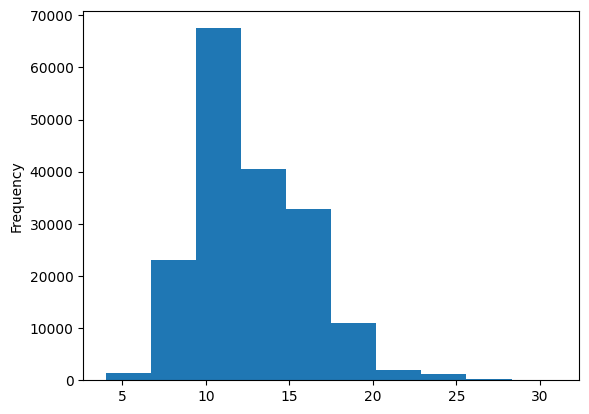

In [12]:
df_train['total_lines'].plot.hist()

#### Get list in to lists

In [13]:
training_sentences = df_train['text'].to_list()
val_sentences = df_val['text'].to_list()
test_sentences = df_test['text'].to_list()

#### One hote encod the labels

In [14]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
One_Hot_Encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = One_Hot_Encoder.fit_transform(df_train['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = One_Hot_Encoder.transform(df_val['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = One_Hot_Encoder.transform(df_test['target'].to_numpy().reshape(-1, 1))

In [15]:
# Label encoding
from sklearn.preprocessing import LabelEncoder
Label_Encoder = LabelEncoder()
train_labels_label_encode = Label_Encoder.fit_transform(df_train['target'].to_numpy())
test_labels_label_encode = Label_Encoder.transform(df_test['target'].to_numpy())
val_labels_label_encode = Label_Encoder.transform(df_val['target'].to_numpy())

#### Helper functions

In [16]:
import datetime
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [17]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [18]:
def calculate_results(y_true, y_pred):
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

### Strating modeling experimnets

#### Model 0: Baseline Model (Naivie Bayes with TF-IDF)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [20]:
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [21]:
model_0.fit(X=training_sentences, y=train_labels_label_encode)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
model_0.score(val_sentences, val_labels_label_encode)

0.7218323844829869

In [23]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
baseline_results = calculate_results(y_true=val_labels_label_encode, y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

#### Prepare data for deep sequnce models

In [25]:
words_counts =  [len(sentence.split()) for sentence in training_sentences]
mean_words_count = np.mean(words_counts)
mean_words_count

26.338269273494777

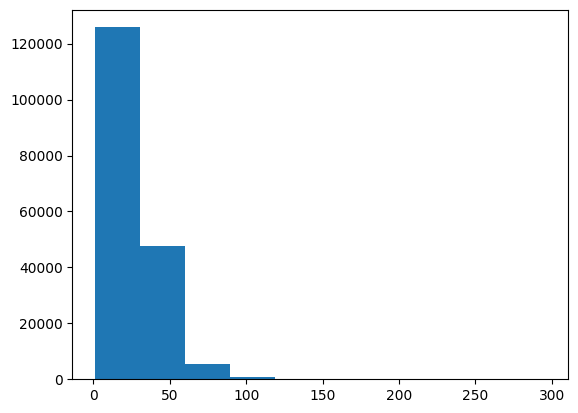

In [26]:
plt.hist(words_counts)
plt.show()

In [27]:
output_seq_len = int(np.percentile(words_counts, 95))
output_seq_len

55

#### Create tokenization and padding

In [28]:
max_tokens = 68000  # form research paper

In [29]:
textVectorization = layers.TextVectorization(max_tokens=max_tokens, output_sequence_length=output_seq_len)

In [30]:
textVectorization.adapt(training_sentences)

In [31]:
length_of_vocab = len(textVectorization.get_vocabulary())
print('Number of words in vocabulary:', length_of_vocab)
textVectorization.get_config()

Number of words in vocabulary: 64841


{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

#### Create text embedding

In [32]:
token_embed = layers.Embedding(input_dim=length_of_vocab, 
                               output_dim=128, 
                               mask_zero=True,
                               name="token_embedding")

#### Create data pipeline

In [33]:
def make_dataset(sentences,labels_one_hot):
    dataset = tf.data.Dataset.from_tensor_slices((sentences, labels_one_hot))
    dataset = dataset.cache()
    # dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [34]:
train_dataset = make_dataset(training_sentences, train_labels_one_hot)
val_dataset = make_dataset(val_sentences, val_labels_one_hot)
test_dataset = make_dataset(test_sentences, test_labels_one_hot)

In [35]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#### Model 1: Conv1D with token embedding

In [36]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = textVectorization(inputs)
x = token_embed(x)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(number_of_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

In [37]:
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [38]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [39]:
model_1.fit(train_dataset,
            epochs=3,
            validation_data=val_dataset,
            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                    experiment_name="model_1_dense")]) 


Saving TensorBoard log files to: tensorflow_hub/model_1_dense/20240218-181354
Epoch 1/3
5627/5627 [==============================] - 61s 10ms/step - loss: 0.6150 - accuracy: 0.7757 - val_loss: 0.5360 - val_accuracy: 0.8101
Epoch 2/3
5627/5627 [==============================] - 57s 10ms/step - loss: 0.4532 - accuracy: 0.8412 - val_loss: 0.5328 - val_accuracy: 0.8114
Epoch 3/3
5627/5627 [==============================] - 58s 10ms/step - loss: 0.3724 - accuracy: 0.8724 - val_loss: 0.5661 - val_accuracy: 0.8066


In [40]:
model_1.evaluate(val_dataset)

  1/945 [..............................] - ETA: 19s - loss: 0.9193 - accuracy: 0.5938

945/945 [==============================] - 3s 4ms/step - loss: 0.5661 - accuracy: 0.8066


[0.566092312335968, 0.8066331148147583]

In [41]:
model_1_pred = model_1.predict(test_dataset)
model_1_pred, model_1_pred.shape

942/942 [==============================] - 3s 3ms/step


(array([[4.38701123e-01, 4.36170474e-02, 1.68012232e-01, 2.00679034e-01,
         1.48990571e-01],
        [8.40777159e-03, 5.47845801e-03, 5.84672689e-01, 6.30037673e-03,
         3.95140737e-01],
        [1.85785379e-04, 9.91846551e-04, 8.77603114e-01, 2.36434542e-04,
         1.20982915e-01],
        ...,
        [8.24801537e-05, 2.00211108e-02, 5.84522844e-04, 3.64891384e-05,
         9.79275346e-01],
        [1.44127465e-03, 1.26528386e-02, 7.32202129e-03, 4.24751459e-04,
         9.78159070e-01],
        [2.31342763e-03, 2.69778073e-01, 3.94406691e-02, 1.85068394e-03,
         6.86617196e-01]], dtype=float32),
 (30135, 5))

In [42]:
tf.argmax(model_1_pred, axis=1)

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 4], dtype=int64)>

In [43]:
model_1_results = calculate_results(y_true=test_labels_label_encode, y_pred=tf.argmax(model_1_pred, axis=1))
model_1_results

{'accuracy': 79.8340799734528,
 'precision': 0.794251934163776,
 'recall': 0.798340799734528,
 'f1': 0.7954030776333202}

#### Model 2: Feature extraction with pretrained token embedding

In [44]:
import tensorflow_hub as hub

embed = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")
embed.trainable = False

In [45]:
# test the universal sentence encoder on a random sentence
random_sentence = random.choice(training_sentences)
print(f"Random sentence: {random_sentence}")
random_embed = embed([random_sentence])
print(f"Sentence after embedding: {random_embed}")
print(f"Length of sentence embedding: {len(random_embed[0])}")

Random sentence: We prospectively enrolled @ patients with medial knee osteoarthritis and randomized them to use either a lateral wedge insole with subtalar strapping ( Group W ) , or a neutral insole with subtalar strapping ( Group N - control ) .
Sentence after embedding: [[-0.03491127 -0.02011354 -0.06503173 -0.05177091 -0.04694232  0.06156898
  -0.01729685 -0.05321388 -0.07403485  0.05590976  0.02400781  0.01153107
  -0.00162346  0.0600105   0.05351781 -0.00549962 -0.06905939  0.01238001
  -0.06335387 -0.04247694  0.06943972  0.03894179  0.01690862  0.01588769
   0.03053452 -0.02221836  0.03739332  0.02537781  0.05919125  0.00670417
   0.06608621  0.07633775  0.07276213  0.05264727 -0.04498719  0.03422077
   0.04917441  0.07648072 -0.03069523 -0.06863178 -0.05313858  0.01834667
   0.06437197  0.01453193  0.04830094  0.05682256  0.0549814   0.03057213
  -0.01349834  0.05517586 -0.04063297 -0.01601344  0.0068494  -0.0073857
   0.06251226 -0.06769309 -0.04144668 -0.00605352 -0.0299645

In [46]:
input = layers.Input(shape=[], dtype=tf.string)
x = embed(input)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(number_of_classes, activation='softmax')(x)
model_2 = tf.keras.Model(input, outputs)

In [47]:
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
                

In [48]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [49]:
model_2.fit(train_dataset,
            epochs=3,
            validation_data=val_dataset,
            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                    experiment_name="model_2_dense")])

Saving TensorBoard log files to: tensorflow_hub/model_2_dense/20240218-181705
Epoch 1/3


5627/5627 [==============================] - 98s 17ms/step - loss: 0.7284 - accuracy: 0.7221 - val_loss: 0.6577 - val_accuracy: 0.7496
Epoch 2/3
5627/5627 [==============================] - 103s 18ms/step - loss: 0.6357 - accuracy: 0.7593 - val_loss: 0.6238 - val_accuracy: 0.7630
Epoch 3/3
5627/5627 [==============================] - 99s 18ms/step - loss: 0.6021 - accuracy: 0.7729 - val_loss: 0.6101 - val_accuracy: 0.7676


In [50]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 14s 15ms/step - loss: 0.6101 - accuracy: 0.7676


[0.6100883483886719, 0.7676088809967041]

In [51]:
model_2_pred = model_2.predict(test_dataset)
model_2_pred, model_2_pred.shape

942/942 [==============================] - 14s 14ms/step


(array([[2.7972952e-01, 1.6362607e-01, 4.9876891e-02, 2.6945540e-01,
         2.3731217e-01],
        [2.8903502e-01, 1.7186375e-02, 2.9265913e-01, 2.9703084e-01,
         1.0408858e-01],
        [1.3130812e-04, 1.0419447e-03, 9.5581913e-01, 1.3793095e-04,
         4.2869594e-02],
        ...,
        [1.0193544e-05, 7.7872304e-03, 9.2305371e-04, 2.3253449e-06,
         9.9127722e-01],
        [4.0998287e-03, 4.9860727e-02, 3.3382541e-03, 6.1422813e-04,
         9.4208694e-01],
        [1.6738292e-02, 7.6350266e-01, 1.0584867e-01, 1.2156521e-02,
         1.0175384e-01]], dtype=float32),
 (30135, 5))

In [52]:
tf.argmax(model_2_pred, axis=1)

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 3, 2, ..., 4, 4, 1], dtype=int64)>

In [53]:
model_2_results = calculate_results(y_true=test_labels_label_encode, y_pred=tf.argmax(model_2_pred, axis=1))
model_2_results

{'accuracy': 76.22697859631657,
 'precision': 0.7588706761876524,
 'recall': 0.7622697859631657,
 'f1': 0.7577369711686476}

#### Model 3: Conv1D with character embedding

In [54]:
def split_chars(text):
    return " ".join(list(text))

In [55]:
train_chars = [split_chars(sentence) for sentence in training_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(f"Original text:\n{training_sentences[0]}\n\nAfter spliting characters:\n{split_chars(training_sentences[0])}")

Original text:
To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .

After spliting characters:
T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .


In [56]:
char_lens = [len(sentence) for sentence in training_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

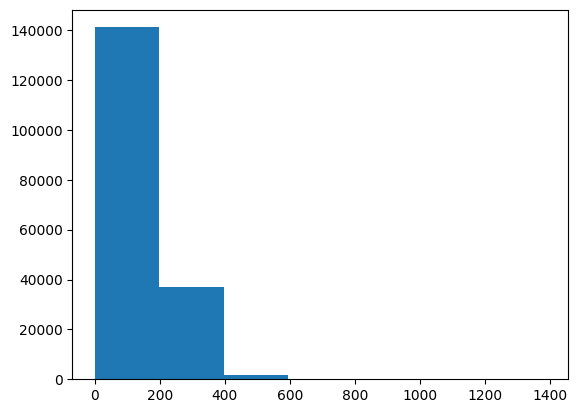

In [57]:
plt.hist(char_lens, bins=7)
plt.show()

In [58]:
output_seq_len = int(np.percentile(char_lens, 95))
output_seq_len

290

In [59]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [65]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_len,
                                    standardize="lower_and_strip_punctuation")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [66]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [67]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
random_train_chars = random.choice(train_chars)
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
N o   s i g n i f i c a n t   d i f f e r e n c e s   w e r e   f o u n d   f o r   a n y   o f   t h e   p a t i e n t s   '   c l i n i c a l   o u t c o m e   m e a s u r e m e n t s   b e t w e e n   t h e   t w o   p r o c e d u r e s   .

Embedded chars (after vectorization and embedding):
[[[ 0.01083639 -0.03292844  0.01420898 ... -0.00697983  0.03239503
    0.04638189]
  [-0.02739674 -0.03560651 -0.04301229 ... -0.03916945 -0.03103626
   -0.0483335 ]
  [ 0.01662847  0.02923331 -0.04539893 ... -0.0247741  -0.00150668
    0.01333559]
  ...
  [-0.03304176  0.04736659  0.00879342 ...  0.01548091  0.03071511
   -0.00090946]
  [-0.03304176  0.04736659  0.00879342 ...  0.01548091  0.03071511
   -0.00090946]
  [-0.03304176  0.04736659  0.00879342 ...  0.01548091  0.03071511
   -0.00090946]]]

Character embedding shape: (1, 290, 25)


In [68]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(number_of_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [69]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [70]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [71]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2781 - accuracy: 0.4793 - val_loss: 1.0543 - val_accuracy: 0.5795
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0212 - accuracy: 0.5866 - val_loss: 0.9566 - val_accuracy: 0.6223
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9433 - accuracy: 0.6268 - val_loss: 0.8882 - val_accuracy: 0.6619


In [72]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.9055 - accuracy: 0.6456


[0.9054731726646423, 0.6456043720245361]

In [73]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[0.08463197, 0.36894628, 0.11018585, 0.30872953, 0.12750626],
       [0.2584197 , 0.38576788, 0.01412116, 0.25400147, 0.08768976],
       [0.10014004, 0.1813488 , 0.26682115, 0.3775142 , 0.07417577],
       ...,
       [0.01516496, 0.04893037, 0.12364849, 0.0268842 , 0.78537196],
       [0.03185086, 0.07078984, 0.3391246 , 0.038053  , 0.5201818 ],
       [0.46315247, 0.34073672, 0.07157793, 0.10350416, 0.02102875]],
      dtype=float32)

In [74]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0], dtype=int64)>

In [75]:
model_3_results = calculate_results(y_true=val_labels_label_encode,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 64.56043956043956,
 'precision': 0.6373620635444559,
 'recall': 0.6456043956043956,
 'f1': 0.6346330089657783}

#### Model 4: Combining pretrained token embedding and character embedding (hybrid embedding layer)

In [76]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = embed(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(number_of_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [77]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   [

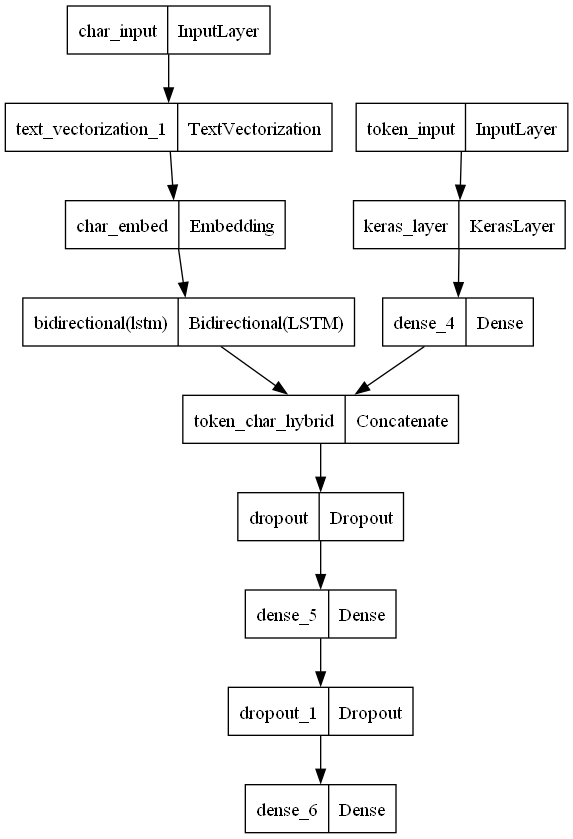

In [78]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [79]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [80]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((training_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [82]:

# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 27s 42ms/step - loss: 0.9779 - accuracy: 0.6097 - val_loss: 0.7840 - val_accuracy: 0.7015
Epoch 2/3
562/562 [==============================] - 21s 38ms/step - loss: 0.7909 - accuracy: 0.6950 - val_loss: 0.7119 - val_accuracy: 0.7314
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.7664 - accuracy: 0.7032 - val_loss: 0.6888 - val_accuracy: 0.7347


In [83]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 24s 26ms/step - loss: 0.6949 - accuracy: 0.7332


[0.6948732137680054, 0.7331523895263672]

In [84]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 27s 28ms/step


array([[3.4086174e-01, 4.6700937e-01, 2.2829184e-03, 1.8303744e-01,
        6.8085706e-03],
       [3.3590260e-01, 4.7154552e-01, 1.9872829e-03, 1.8918300e-01,
        1.3815673e-03],
       [2.7984208e-01, 1.5129003e-01, 3.4899753e-02, 4.9831223e-01,
        3.5655875e-02],
       ...,
       [3.8822027e-04, 4.5418227e-03, 4.4779867e-02, 1.1532297e-04,
        9.5017469e-01],
       [8.0989795e-03, 7.7665143e-02, 2.1974893e-01, 3.6402561e-03,
        6.9084668e-01],
       [2.2127067e-01, 4.2667317e-01, 2.4213880e-01, 3.2694619e-02,
        7.7222794e-02]], dtype=float32)

In [85]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1], dtype=int64)>

In [86]:
model_4_results = calculate_results(y_true=val_labels_label_encode,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.31523897788958,
 'precision': 0.7347633588613875,
 'recall': 0.7331523897788959,
 'f1': 0.730412346327765}